In [14]:
%matplotlib inline
import pickle
import os

---
title: Maximum Likelihood Estimation of Custom Models in Python with StatsModels
tags: Statistics, Python
---

Maximum likelihood estimation is a common method for fitting statistical models.  In Python, it is quite possible to fit maximum likelihood models using just [`scipy.optimize`](http://docs.scipy.org/doc/scipy/reference/optimize.html). Over time, however, I have come to prefer the convenience provided by [`statsmodels`'](http://statsmodels.sourceforge.net/) [`GenericLikelihoodModel`](http://statsmodels.sourceforge.net/devel/dev/generated/statsmodels.base.model.GenericLikelihoodModel.html).  In this post, I will show how easy it is to subclass `GenericLikelihoodModel` and take advantage of much of `statsmodels`' well-developed machinery for maximum likelihood estimation of custom models.

#### Zero-inflated Poisson models

The model we use for this demonstration is a [zero-inflated Poisson model](http://en.wikipedia.org/wiki/Zero-inflated_model#Zero-inflated_Poisson).  This is a model for count data that generalizes the Poisson model by allowing for an overabundance of zero observations.

The model has two parameters, $\pi$, the proportion of excess zero observations, and $\lambda$, the mean of the Poisson distribution.  We assume that observations from this model are generated as follows.  First, a weighted coin with probability $\pi$ of landing on heads is flipped.  If the result is heads, the observation is zero.  If the result is tails, the observation is generated from a Poisson distribution with mean $\lambda$.  Note that there are two ways for an observation to be zero under this model:

1. the coin is heads, and
2. the coin is tails, and the sample from the Poisson distribution is zero.

If $X$ has a zero-inflated Poisson distribution with parameters $\pi$ and $\lambda$, its probability mass function is given by

$$\begin{align*}
P(X = 0)
    & = \pi + (1 - \pi)\ e^{-\lambda} \\
P(X = x)
    & = (1 - \pi)\ e^{-\lambda}\ \frac{\lambda^x}{x!} \textrm{ for } x > 0.
\end{align*}$$

In this post, we will use the parameter values $\pi = 0.3$ and $\lambda = 2$.  The probability mass function of the zero-inflated Poisson distribution is shown below, next to a normal Poisson distribution, for comparison.

In [2]:
from __future__ import division

from matplotlib import  pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel

In [4]:
#pmf = probabilty mass function (?)
#def zip_pmf(x, pi=pi, lambda_=lambda_):
#    if pi < 0 or pi > 1 or lambda_ <= 0:
#        return np.zeros_like(x)
#    else:
#        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)
    


def round1_likelihood(degrees, answers, mu, sigma2):
# likelihood(R|mu, sigma) = 
    likelihood = 1
    # model the product
    for t in range(len(degrees)):
        # do we want the loc=0 here?
        likelihood = likelihood * stats.bernoulli.pmf(answers[t], phi(degrees[t], mu, sigma2))
    #print('The likelihood of these values is', likelihood)
    return likelihood

#### Maximum likelihood estimation

First we generate 1,000 observations from the zero-inflated model.

We are now ready to estimate $\pi$ and $\lambda$ by maximum likelihood.  To do so, we define a class that inherits from `statsmodels`' `GenericLikelihoodModel` as follows.

In [30]:
from scipy import stats, optimize
from math import erf, sqrt, exp
import math

In [31]:
def phi(x, mu, sigma2):
    # rewrote it to take sigma2 and then take the square root - not sure this is numerically smart... try without
    sigma = math.sqrt(sigma2)
    distribution = stats.norm(loc = mu, scale = sigma)
    return distribution.cdf(x)

In [47]:
class BernoulliCumNorm(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(BernoulliCumNorm, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        mu = params[0]
        sigma2 = params[1]

        return -np.log(round1_likelihood(self.endog, self.exog, mu=mu, sigma2=sigma2))
    
    def fit(self, start_params=None, maxiter=1000, maxfun=5000, **kwds):
        if start_params is None:
            # maybe witch endog & exog like done here but probably not (?) 
            #lambda_start = self.endog.mean()
            mu_start = self.exog.mean()
            sigma2_start = 2
            
            start_params = np.array([mu_start, sigma2_start])
            
        return super(BernoulliCumNorm, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

In [48]:
for filename in os.listdir('data/preprocessed/audio'):
    if filename.endswith('.p'):
        print(filename)
        data = pickle.load( open('data/preprocessed/audio/' + filename, "rb" ) )
        print(data)

participant1.p
[[-2.25  4.5   2.25 -6.75  6.75 -4.5   2.25  6.75 -2.25 -6.75  4.5  -4.5
   6.75  2.25  4.5  -2.25 -4.5  -6.75 -4.5   4.5   6.75 -2.25  2.25 -6.75
  -6.75 -2.25 -4.5   4.5   2.25  6.75 -6.75  4.5   2.25  6.75 -2.25 -4.5
   4.5  -6.75 -4.5   6.75  2.25 -2.25  4.5  -6.75 -2.25 -4.5   2.25  6.75
   4.5  -6.75 -2.25 -4.5   2.25  6.75  4.5   6.75 -2.25  2.25 -4.5  -6.75]
 [ 0.    1.    0.    0.    1.    0.    1.    1.    0.    0.    1.    0.    1.
   0.    1.    1.    0.    0.    0.    1.    1.    0.    1.    0.    0.    0.
   0.    1.    1.    1.    0.    1.    1.    1.    0.    0.    1.    0.    0.
   1.    1.    0.    1.    0.    0.    0.    1.    1.    1.    0.    0.    0.
   1.    1.    1.    1.    0.    1.    0.    0.  ]]
participant10.p
[[ 0.   -6.75 -2.25  4.5   2.25 -4.5   6.75 -6.75  2.25  0.   -4.5   6.75
   4.5  -2.25  0.   -6.75 -2.25  2.25  6.75 -4.5   4.5  -4.5   2.25  6.75
   4.5   0.   -6.75 -2.25 -6.75  2.25  6.75 -4.5   0.    4.5  -2.25 -4.5
   0.    6.75 -

The key component of this class is the method `nloglikeobs`, which returns the negative log likelihood of each observed value in `endog`.  Secondarily, we must also supply reasonable initial guesses of the parameters in `fit`.  Obtaining the maximum likelihood estimate is now simple.

In [49]:
data[0,:]

array([ 2.25, -4.5 ,  6.75, -6.75, -2.25,  4.5 ,  0.  , -2.25, -6.75,
        4.5 ,  0.  , -4.5 ,  6.75,  2.25, -6.75,  0.  ,  2.25, -2.25,
        4.5 , -4.5 ,  6.75, -6.75,  4.5 ,  6.75,  0.  , -2.25, -4.5 ,
        2.25, -4.5 , -6.75,  2.25,  0.  ,  4.5 , -2.25,  6.75,  2.25,
        4.5 ,  0.  ,  6.75, -4.5 , -6.75, -2.25,  0.  , -2.25,  2.25,
       -6.75,  4.5 ,  6.75, -4.5 ,  0.  ,  6.75,  2.25, -2.25, -4.5 ,
        4.5 , -6.75, -4.5 , -2.25,  0.  ,  2.25,  6.75,  4.5 , -6.75,
        0.  , -2.25,  4.5 , -4.5 ,  6.75,  2.25, -6.75])

In [50]:
model = BernoulliCumNorm(data[1,:], data[0,:])
results = model.fit()

/Users/polaschwoebel/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [51]:
results.mle_retvals

{'converged': False,
 'fcalls': 3999,
 'fopt': inf,
 'iterations': 1000,
 'warnflag': 2}

We see that we have estimated the parameters fairly well.

In [52]:
results.params


array([ 0.,  2.])

There are many advantages to buying into the `statsmodels` ecosystem and subclassing `GenericLikelihoodModel`.  The already-written `statsmodels` code handles storing the observations and the interaction with `scipy.optimize` for us.  (It is possible to control the use of `scipy.optimize` through keyword arguments to `fit`.)

We also gain access to many of `statsmodels`' built in model analysis tools.  For example, we can use bootstrap resampling to estimate the variation in our parameter estimates.

In [13]:
boot_mean, boot_std, boot_samples = results.bootstrap(nrep=500, store=True)
boot_pis = boot_samples[:, 0]
boot_lambdas = boot_samples[:, 1]

<class '__main__.ZeroInflatedPoisson'>


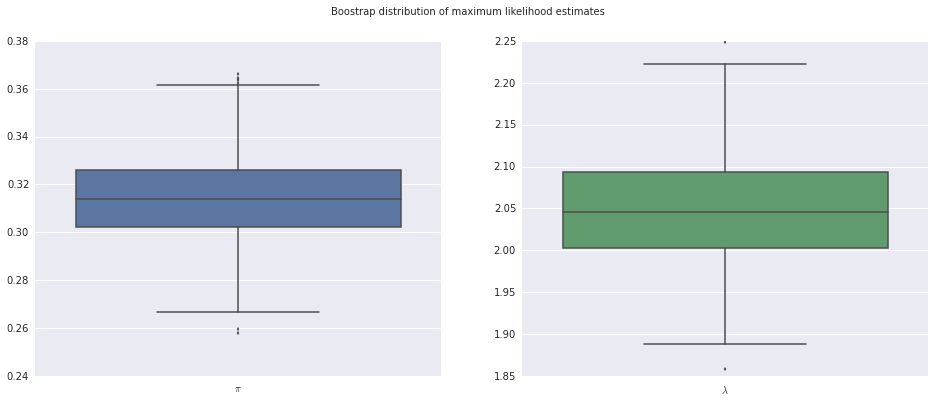

In [14]:
fig, (pi_ax, lambda_ax) = plt.subplots(ncols=2, figsize=(16, 6))

sns.boxplot(boot_pis, ax=pi_ax, names=['$\pi$'], color=palette[0]);
sns.boxplot(boot_lambdas, ax=lambda_ax, names=['$\lambda$'], color=palette[1]);

fig.suptitle('Boostrap distribution of maximum likelihood estimates');

The next time you are fitting a model using maximum likelihood, try integrating with `statsmodels` to take advantage of the significant amount of work that has gone into its ecosystem.